In [1]:
from jax_kan.trainer import Trainer
from flax import linen as nn
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
from eins import ElementwiseOps as E

theme, cs = rp.mpl_setup(True)

/home/nicholas/anaconda3/lib/python3.11/site-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Callable[..., typing.Any] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(
/home/nicholas/anaconda3/lib/python3.11/site-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Sequence[int] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/late

In [2]:
import optax
from jax_kan.utils import Identity
from jax_kan.data import DataFrameDataLoader
from jax_kan.kan import KANLayer
from jax_kan.kan import KAN

import rich

rich.console.Console()
rich.reconfigure(force_jupyter=True, width=250)

In [29]:
target = 'expt_gap'
loss_norm_fn = jnp.abs
dataset_splits = (3, 4, 5, 6, 7)
batch_size = 64
use_prodigy = False
n_folds = 4
start_frac = 0.1
end_frac = 0.3
n_epochs = 600
dtype = jnp.float32

n_coef = 5
node_dropout = 0.0
order = 3
spline_input_map = lambda x: nn.tanh(x * 0.8)
hidden_dim = None
inner_dims = [48, 32, 16, 16]
normalization = Identity
base_act = nn.tanh
weight_decay = 0.01
base_lr = 3e-3
gamma = 0.99
alpha = None

# -------------------------------

target_transforms = {
    'bandgap': lambda x: x,
    'yield_raw': E.from_func(lambda x: E.expm1(x + 7.5)),
    'delta_e': lambda x: x * 4,
    'expt_gap': nn.elu,
}

target_transforms['yield_featurized'] = target_transforms['yield_raw']

if target in ('bandgap', 'delta_e'):
    df = pd.read_feather('datasets/mpc_full_feats_scaled_split.feather')
    df = df[df['dataset_split'].isin(dataset_splits)]
    df = df.select_dtypes('number').drop(columns=['TSNE_x', 'TSNE_y', 'umap_x', 'umap_y', 'dataset_split'])
elif target == 'yield_raw':
    df = pd.read_feather('datasets/steels_raw.feather')
elif target == 'yield_featurized':
    df = pd.read_feather('datasets/steels_featurized.feather')
elif target == 'expt_gap':
    df = pd.read_feather('datasets/mb_expt_gap.feather')
else:
    msg = f'Unknown target: {target}'
    raise ValueError(msg)

dl = DataFrameDataLoader(df, batch_size=batch_size, target_col=df.columns[-1])

steps_in_epoch = 4 * dl.num_batches // 5

kwargs = {
    'n_coef': n_coef,
    'inner_dims': inner_dims,
    'normalization': normalization,
    'hidden_dim': hidden_dim,
    'out_hidden_dim': 1,
    'layer_templ': KANLayer(
        1,
        1,
        order=order,
        dropout_rate=node_dropout,
        base_act=base_act,
        spline_input_map=spline_input_map,
        alpha=alpha,
    ),
}

if use_prodigy:
    sched = optax.warmup_cosine_decay_schedule(0.1, 1., (steps_in_epoch * n_epochs) // 20, steps_in_epoch * n_epochs)
else:
    sched = optax.cosine_onecycle_schedule(
        transition_steps=steps_in_epoch * n_epochs,
        peak_value=base_lr,
        pct_start=0.05,
        div_factor=1 / start_frac,
        final_div_factor=1 / end_frac,
    )
if use_prodigy:
    opt = optax.contrib.prodigy(sched, weight_decay=weight_decay)
else:
    opt = optax.adamw(sched, weight_decay=weight_decay, nesterov=nesterov)
    # opt = optax.lion(lambda x: sched(x) / 3, weight_decay=weight_decay * 3)
tx = optax.chain(
    opt,
    # optax.clip_by_global_norm(max_norm=1.0),
)

kan = KAN(in_dim=dl.sample_batch().in_dim, out_dim=1, final_act=target_transforms[target], **kwargs)

trainer = Trainer(kan, dl, optimizer=tx)

for fold in range(1):
    trainer.use_fold(fold, k=n_folds)
    trainer.fit(n_epochs=n_epochs)

    hist = trainer.epoch_df[['train_loss', 'valid_loss']]
    hist.plot()
    plt.ylim(hist.min().min(), hist.iloc[30:].max().max())
    rp.line_labels()
    plt.show()

Output()

KeyboardInterrupt: 

- better initialization: figure out mathematically how to make each layer roughly the identity
  without using residuals
- figure out why deep networks don't work well. Can we add skip connections, or residuals, or
  something?
- grid extension
- hermite polynomials?

<Axes: >

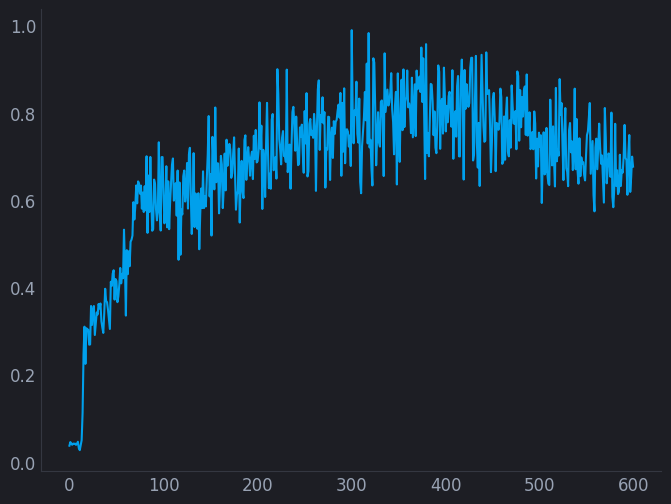

In [26]:
trainer.epoch_df['grad_norm'].plot()